In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision 
import matplotlib.pyplot as plt
from time import time as tm

# Import TorchSeq2PC 
!git clone https://github.com/RobertRosenbaum/Torch2PC.git
from Torch2PC import TorchSeq2PC as T2PC  

# Seed rng
torch.manual_seed(0)

# # This patches an error that sometimes arises in
# # downloading MNIST
# from six.moves import urllib
# opener = urllib.request.build_opener()
# opener.addheaders = [('User-agent', 'Mozilla/5.0')]
# urllib.request.install_opener(opener)

# This seems to be a more reliable and faster
# source for MNIST
!wget -nc www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

# Load training and testing data from MNIST dataset
# These lines return data structures that contain
# the training and testing data 
from torchvision.datasets import MNIST

# Get training data structure
train_dataset = MNIST('./', 
      train=True, 
      transform=torchvision.transforms.ToTensor(),  
      download=True)

# Number of trainin data points
m = len(train_dataset)

# Print the size of the training data set
print('\n\n\n')
print("Number of data points in training set = ",m)
print("Size of training inputs (X)=",train_dataset.data.size())
print("Size of training labels (Y)=",train_dataset.targets.size())

# Define batch size
batch_size = 300      # Batch size to use with training data

# Create data loader. 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)


# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ',device)

# Define the nunmber of epochs, learning rate, 
# and how often to print progress
num_epochs=2
LearningRate=.002
PrintEvery=50

# Choose an optimizer
WhichOptimizer=torch.optim.Adam

# Compute size of each batch
steps_per_epoch = len(train_loader) 
total_num_steps  = num_epochs*steps_per_epoch
print("steps per epoch (mini batch size)=",steps_per_epoch)


Cloning into 'Torch2PC'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 107 (delta 2), reused 0 (delta 0), pack-reused 98
Receiving objects: 100% (107/107), 54.52 KiB | 1.43 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Running TorchSeq2PC.py
--2023-05-17 22:06:44--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-05-17 22:06:45--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  5.85MB/s    in 18s

In [2]:

# Define model using Sequential. 
model=nn.Sequential(
    
    nn.Sequential(nn.Conv2d(1,10,3),
    nn.ReLU(),
    nn.MaxPool2d(2)
    ),

    nn.Sequential(
    nn.Conv2d(10,5,3),
    nn.ReLU(),
    nn.Flatten()
    ),

 nn.Sequential(    
    nn.Linear(5*11*11,50),
    #nn.BatchNorm1d(50),
    nn.ReLU()
    ),

 nn.Sequential(    
    nn.Linear(50,30),
    nn.ReLU()
    ),


nn.Sequential(
   nn.Linear(30,10)
 )

).to(device)

# Define the loss function
LossFun = nn.CrossEntropyLoss()

# Compute one batch of output and loss to make sure
# things are working
with torch.no_grad():
  TrainingIterator=iter(train_loader)
  X,Y=next(TrainingIterator)  
  X=X.to(device)
  Y=Y.to(device)
  Yhat=model(X).to(device)
  print('output shape = ',Yhat.shape)
  print('loss on initial model = ',LossFun(Yhat,Y).item())


NumParams=sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in model =',NumParams)



output shape =  torch.Size([300, 10])
loss on initial model =  2.3059136867523193
Number of trainable parameters in model = 32695


In [3]:
# Define PC hyperparameters

ErrType="Strict"
eta=.1
n=20

epoch = 0 step = 0 Loss = 2.303985118865967
epoch = 0 step = 50 Loss = 0.5982927680015564
epoch = 0 step = 100 Loss = 0.4362761974334717
epoch = 0 step = 150 Loss = 0.2855041027069092
epoch = 1 step = 0 Loss = 0.2728539705276489
epoch = 1 step = 50 Loss = 0.22864319384098053
epoch = 1 step = 100 Loss = 0.22748245298862457
epoch = 1 step = 150 Loss = 0.19112104177474976
Training time =  426.92914628982544 sec


Text(0.5, 0, 'iteration number')

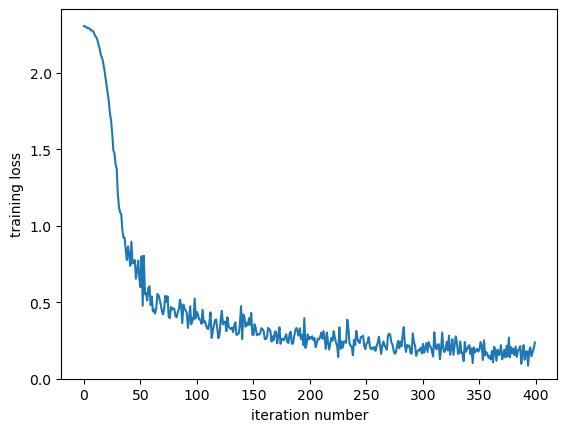

In [4]:

# Define the optimizer
optimizer = WhichOptimizer(model.parameters(), lr=LearningRate)

# Initialize vector to store losses
LossesToPlot=np.zeros(total_num_steps)


j=0     # Counters
jj=0    
t1=tm() # Get start time
for k in range(num_epochs):

  # Re-initialize the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)
  
  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=Y.to(device)

    # Perform inference on this batch
    vhat,Loss,dLdy,v,epsilon=T2PC.PCInfer(model,LossFun,X,Y,ErrType,eta,n)

    # Update parameters    
    optimizer.step() 

    # Zero-out gradients     
    model.zero_grad()
    optimizer.zero_grad()

    # Print and store loss
    with torch.no_grad():
      if(i%PrintEvery==0):
        print('epoch =',k,'step =',i,'Loss =',Loss.item())
      LossesToPlot[jj]=Loss.item() 
      jj+=1

# Compute and print time spent training
tTrain=tm()-t1
print('Training time = ',tTrain,'sec')

# Plot the loss curve
plt.figure()
plt.plot(LossesToPlot)
plt.ylim(bottom=0)  
plt.ylabel('training loss')
plt.xlabel('iteration number')

